# Custom OCR using PyTorch

In [2]:
# import the requiered packages:
import os
import torch
import numpy as np 
import seaborn as sns 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm 
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

%matplotlib inline

### 1. Data Preparation

In [3]:
# Custom Dataset
class OCRDataset(Dataset):
    """Custom Dataset for loading OCR character images"""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the character folders (A-Z, 0-9)
            transform (callable, optional): Optional transform to be applied
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get class names from folder names
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        
        # Load all image paths and their corresponding labels
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Add other formats if needed
                    self.images.append((
                        os.path.join(cls_dir, img_name),
                        self.class_to_idx[cls]
                    ))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        
        # Load image (using PIL as it handles different image formats well)
        image = Image.open(img_path)
        
        # Convert to grayscale if not already
        if image.mode != 'L':
            image = image.convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_class_names(self):
        """Helper method to get the ordered list of class names"""
        return self.classes

In [4]:
# Custom transformations for 37x37 images
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(48),  # Slightly larger for pretrained models
    transforms.RandomCrop(37),  # Random 37x37 crops
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomAffine(0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(37),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
# Defined paths - MODIFY THESE TO YOUR ACTUAL PATHS
train_dir = '/home/aman-nvidia/My_files/ai_projects/ocr_one/ocr_dataset/training_data'
test_dir = '/home/aman-nvidia/My_files/ai_projects/ocr_one/ocr_dataset/testing_data'

In [6]:
# Create datasets
train_dataset = OCRDataset(train_dir, transform=train_transform)
test_dataset = OCRDataset(test_dir, transform=test_transform)

In [7]:
# Print class names
print("Training class names:", train_dataset.get_class_names())
print("Testing class names:", test_dataset.get_class_names())

Training class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Testing class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 3. Build DNN Model

In [11]:
# Define model adaptation function
def get_pretrained_model(model_name='resnet18', num_classes=36, dropout_rate=0.5):
    """Enhanced pretrained model loader with better adaptation for OCR"""
    # Print selected model with clear label
    print(f"\n{'='*50}")
    print(f"Loading pretrained model: {model_name.upper()}")
    print(f"Number of classes: {num_classes}")
    print(f"Dropout rate: {dropout_rate}")
    print(f"{'='*50}\n")
    
    if model_name == 'resnet18':
        print("Configuring ResNet18 architecture for OCR...")
        model = models.resnet18(weights='DEFAULT')
        model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
        
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, num_classes)
        )
        
    elif model_name == 'efficientnet_b0':
        print("Configuring EfficientNet-B0 architecture for OCR...")
        model = models.efficientnet_b0(weights='DEFAULT')
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 256),
            nn.SiLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, num_classes)
        )
        
    elif model_name == 'mobilenetv3_small':
        print("Configuring MobileNetV3-Small architecture for OCR...")
        model = models.mobilenet_v3_small(weights='DEFAULT')
        model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.Hardswish(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        
    else:
        raise ValueError(f"Unknown model: {model_name}. Choose from: resnet18, efficientnet_b0, mobilenetv3_small")
    
    # Print weight initialization info
    print(f"\nInitializing weights for {model_name}...")
    print(f"Using Kaiming Normal for Conv2d layers")
    print(f"Using Constant(1) for BatchNorm weights")
    print(f"Using Normal(0,0.01) for Linear layers\n")
    
    # Initialize weights
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
    
    # Print final confirmation
    print(f"Successfully loaded {model_name} with {num_classes} output classes")
    print(f"{'='*50}\n")
    
    return model

In [12]:
# Initialize model
model = get_pretrained_model('resnet18', num_classes=36)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Loading pretrained model: RESNET18
Number of classes: 36
Dropout rate: 0.5

Configuring ResNet18 architecture for OCR...

Initializing weights for resnet18...
Using Kaiming Normal for Conv2d layers
Using Constant(1) for BatchNorm weights
Using Normal(0,0.01) for Linear layers

Successfully loaded resnet18 with 36 output classes



## 4. Train loop

In [13]:
# Training setup
num_epochs = 5
criterion = nn.CrossEntropyLoss()

In [14]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
if hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
elif hasattr(model, 'fc'):
    for param in model.fc.parameters():
        param.requires_grad = True

optimizer = optim.AdamW([
    {'params': [p for p in model.parameters() if p.requires_grad]},
], lr=0.001)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                       max_lr=0.01,
                                       steps_per_epoch=len(train_loader),
                                       epochs=num_epochs)

In [15]:
# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total


In [ ]:
# # Training function
# def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
#     best_acc = 0.0
#     early_stop_counter = 0
#     patience = 3  # Stop if no improvement for 3 epochs
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0
        
#         for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
#             images, labels = images.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
            
#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
#             optimizer.step()
#             # Moved scheduler step to after epoch
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
        
#         # Update scheduler based on epoch (not batch)
#         scheduler.step()
        
#         train_loss = running_loss / len(train_loader)
#         train_acc = 100 * correct / total
        
#         # Validation phase
#         val_loss, val_acc = evaluate(model, test_loader, criterion)
        
#         print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
        
#         # Early stopping check
#         if val_acc > best_acc + 0.001:  # Small threshold for improvement
#             best_acc = val_acc
#             early_stop_counter = 0
#             torch.save(model.state_dict(), 'best_ocr_model.pth')
#         else:
#             early_stop_counter += 1
#             if early_stop_counter >= patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break
    
#     print(f'Training complete. Best validation accuracy: {best_acc:.2f}%')


In [16]:
# Function for training:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    lrs = []
    
    best_acc = 0.0
    early_stop_counter = 0
    patience = 3
    
    # Print training header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc':<12} | {'Val Loss':<12} | {'Val Acc':<12} | {'LR':<10}")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        val_loss, val_acc = evaluate(model, test_loader, criterion)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_acc)
        else:
            scheduler.step()
        
        # Print epoch statistics with descriptive labels
        print(f"Epoch {epoch+1:<3} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f}")
        
        if val_acc > best_acc + 0.001:
            best_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_ocr_model_{num_epochs}.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break
    
    # After training completes, generate the plots
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final summary with clear labels
    print("\nTraining complete!")
    print("-" * 60)
    print(f"Best validation accuracy: {best_acc:.2f}%")
    print(f"Final training accuracy: {train_accs[-1]:.2f}%")
    print(f"Final validation accuracy: {val_accs[-1]:.2f}%")
    print(f"Total epochs trained: {len(train_accs)}")
    print("-" * 60)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'lrs': lrs
    }

In [17]:
# Unfreeze all layers for final training
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=0.0001)

Epoch   | Train Loss   | Train Acc    | Val Loss     | Val Acc      | LR        
--------------------------------------------------------------------------------


Epoch 1/5: 100%|██████████| 967/967 [06:46<00:00,  2.38it/s]
/home/aman-nvidia/My_files/ai_projects/ai_venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1   | Train Loss: 1.5520 | Train Acc: 61.14% | Val Loss: 0.4478 | Val Acc: 88.82% | LR: 0.000100


Epoch 2/5: 100%|██████████| 967/967 [05:13<00:00,  3.09it/s]


Epoch 2   | Train Loss: 0.4445 | Train Acc: 87.12% | Val Loss: 0.2757 | Val Acc: 90.58% | LR: 0.000100


Epoch 3/5: 100%|██████████| 967/967 [04:37<00:00,  3.48it/s]


Epoch 3   | Train Loss: 0.3205 | Train Acc: 89.84% | Val Loss: 0.5107 | Val Acc: 85.42% | LR: 0.000100


Epoch 4/5: 100%|██████████| 967/967 [04:37<00:00,  3.48it/s]


Epoch 4   | Train Loss: 0.2729 | Train Acc: 91.09% | Val Loss: 0.3105 | Val Acc: 89.55% | LR: 0.000100


Epoch 5/5: 100%|██████████| 967/967 [04:37<00:00,  3.48it/s]


Epoch 5   | Train Loss: 0.2431 | Train Acc: 91.92% | Val Loss: 0.4654 | Val Acc: 88.00% | LR: 0.000100

Early stopping triggered at epoch 5


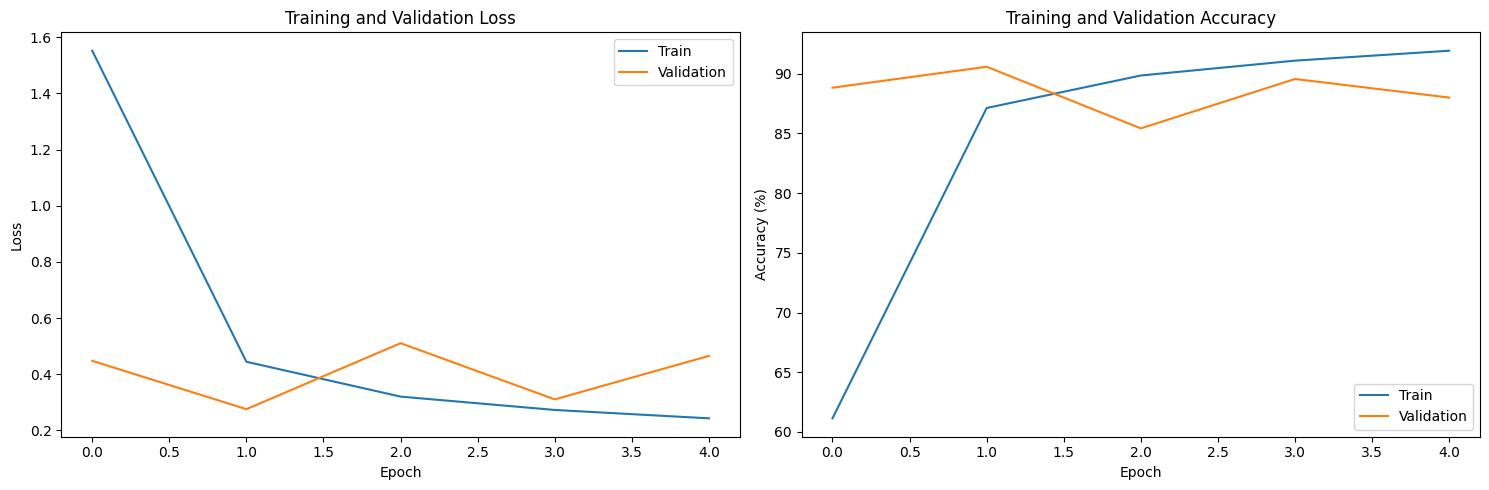


Training complete!
------------------------------------------------------------
Best validation accuracy: 90.58%
Final training accuracy: 91.92%
Final validation accuracy: 88.00%
Total epochs trained: 5
------------------------------------------------------------


In [18]:
# Start training
metrics = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs
)

### Plot the Condusion Matrix

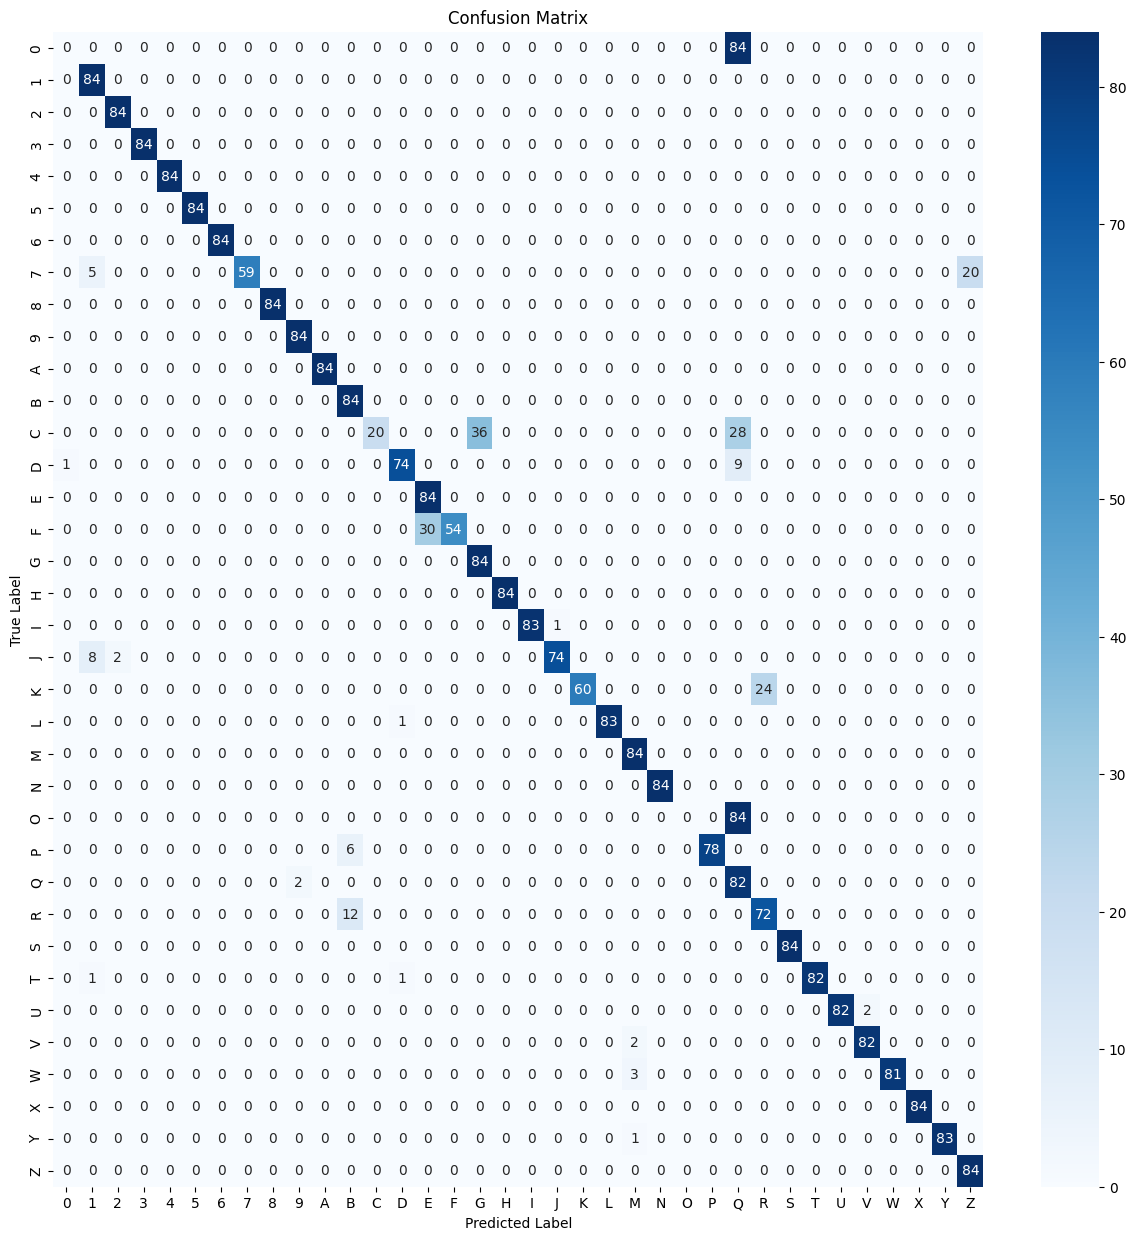

In [19]:
# Plot
def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get class names from your dataset
class_names = train_dataset.get_class_names()

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names)